In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib
import os

In [2]:
file_path = r"D:\Programming\Projects\Data\Diabetes\diabetes_binary_health_indicators_BRFSS2015.csv"

df = pd.read_csv(file_path)

In [4]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


DATA PREPROCESSING AND FEATURE ENGINEERING

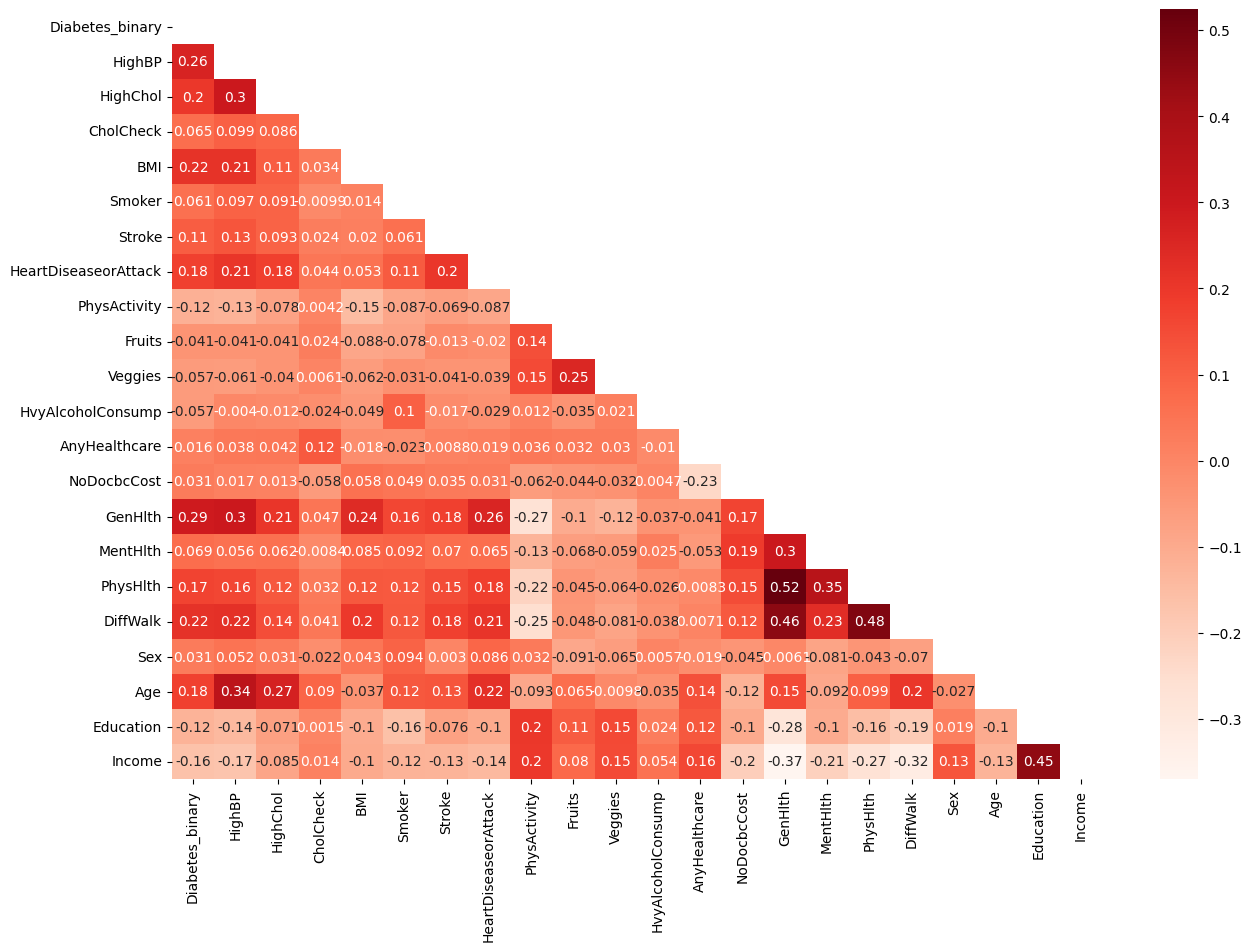

In [28]:
plt.figure(figsize=(15,10))
mask=np.triu(df.corr())
sns.heatmap(df.corr(),mask=mask,annot=True,cmap='Reds')
plt.show()

In [67]:
df.select_dtypes('number').columns

features = ["Age", "HighBP", "HighChol","BMI","PhysHlth","GenHlth", "DiffWalk", "HeartDiseaseorAttack"]

X = df[features]

y = df["Diabetes_binary"]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [69]:
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)

In [49]:
df["Diabetes_binary"].value_counts()

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64

In [70]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

XGBOOST MODEL

In [51]:
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

xgboost_model = XGBClassifier(random_state=42, eval_metric="logloss")

params = {
    "max_depth": [3,5,7],
    "learning_rate": [0.01,0.05,0.1],
    "n_estimators": [100,200,300],
    "subsample": [0.7,0.8,1.0],
    "colsample_bytree": [0.7,0.8,1.0],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1,2,3]
}

model = RandomizedSearchCV(estimator=xgboost_model, param_distributions=params, n_iter=50, scoring="accuracy", n_jobs=-1, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

best_model = model.best_estimator_
best_model.fit(X_train_resampled, y_train_resampled, verbose=False)

joblib.dump(best_model, "db_model_fe.pkl")
joblib.dump(standard_scaler, "db_standard_scaler_fe.pkl")

print("Model saved")


Model saved


PREDICTIONS AND ACCURACY

In [71]:
main_model = joblib.load("db_model_fe.pkl")
sss = joblib.load("db_standard_scaler_fe.pkl")

In [72]:
X_test_new = sss.transform(X_test)

predictions = main_model.predict(X_test_new)

accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.799


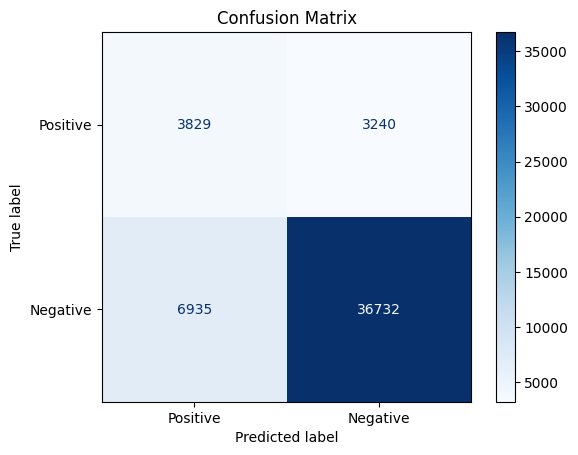

In [74]:
cm = confusion_matrix(y_test, predictions, labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [73]:
c_report = classification_report(y_test, predictions)
print(c_report)

              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88     43667
         1.0       0.36      0.54      0.43      7069

    accuracy                           0.80     50736
   macro avg       0.64      0.69      0.65     50736
weighted avg       0.84      0.80      0.82     50736



FEATURES IMPORTANCE

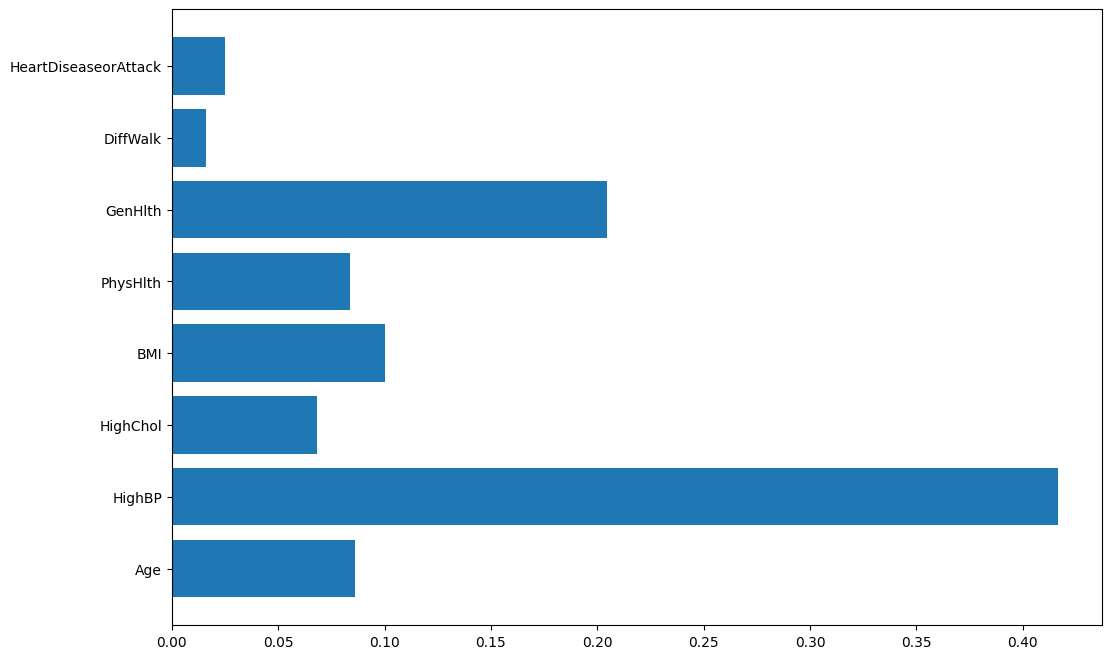

In [75]:
features = ["Age", "HighBP", "HighChol","BMI","PhysHlth","GenHlth", "DiffWalk", "HeartDiseaseorAttack"]
imp = main_model.feature_importances_
plt.figure(figsize=(12, 8))
plt.barh(features, imp)
plt.show()